In [47]:
import math
from datetime import date, timedelta

import pandas as pd
from demeter.indicator.common import get_real_n
from demeter import TokenInfo, Actuator, Strategy, RowData, simple_moving_average, realized_volatility, ChainType, MarketInfo, PriceTrigger, PeriodTrigger, \
    BaseAction
from demeter.result import performance_metrics
from demeter.uniswap import UniV3Pool, UniLpMarket
from typing import List
from demeter.broker import AccountStatus
from matplotlib.pylab import plt
import matplotlib.dates as mdates
#Set matplotlib to show formatted account status
def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()

#Make plot about price and account value / position net value
def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name]["net_value"]
    value_in_account = account_status["tokens"]["USDC"] + account_status["tokens"]["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()


In [48]:
# c = 2
# class MovingAverageStrategy(Strategy):

#     def initialize(self):
#         """
#         This function is called before main loop is executed.
#         you can prepare data, or register trigger here
#         """

#         # Add a simple moving average line for backtesting data. In backtesting,
#         # we will add/remove liquidity according to this line.
#         self.add_column(market_key, "sma_1d", simple_moving_average(self.data[market_key].price, window=timedelta(hours=16)))
#         self.add_column(market_key, "volatility_1d", realized_volatility(self.data[market_key].price, timedelta(days=1), timedelta(days=1)))
#         # Register a trigger, every day, we split both assets into two shares of equal value
#         self.triggers.append(PeriodTrigger(time_delta=timedelta(days=2), trigger_immediately=True, do=self.work))
#         self.markets.default.even_rebalance(self.data[market_key].iloc[0]["price"])
        

#     def work(self, row_data: RowData):
#         self.match_price = []
#         self.match_price.append(row_data.prices[eth.name])

#         lp_market: UniLpMarket = self.broker.markets[market_key]
#         lp_row_data = row_data.market_status[market_key]
#         if len(lp_market.positions) > 0:
#             lp_market.remove_all_liquidity()
#             lp_market.even_rebalance(row_data.prices[eth.name])
#         if math.isnan(lp_row_data.volatility_1d):
#             return
#         limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility_1d
#         # lp_market.add_liquidity(lp_row_data.sma_1d - limit * 1.3, lp_row_data.sma_1d + limit * 1.3)
#         if self.broker.assets[market.base_token].balance > 0:
#             lp_market.add_liquidity(lp_row_data.sma_1d - limit, lp_row_data.sma_1d+limit)
#         else:
#             lp_market.add_liquidity(lp_row_data.sma_1d - limit, lp_row_data.sma_1d + limit)

In [49]:
c = 2
class MovingAverageStrategy(Strategy):

    def initialize(self):
        """
        This function is called before main loop is executed.
        you can prepare data, or register trigger here
        """

        # Add a simple moving average line for backtesting data. In backtesting,
        # we will add/remove liquidity according to this line.
        self.add_column(market_key, "sma_1d", simple_moving_average(self.data[market_key].price, window=timedelta(hours=16)))
        self.add_column(market_key, "volatility_1d", realized_volatility(self.data[market_key].price, timedelta(days=1), timedelta(days=1)))
        # Register a trigger, every day, we split both assets into two shares of equal value
        self.current_lower_price = None
        self.current_upper_price = None

        # Register the PriceTrigger
        self.triggers.append(PriceTrigger(
            condition=self.is_price_out_of_range,
            do=self.handle_out_of_range_price
        ))
        
        self.markets.default.even_rebalance(self.data[market_key].iloc[0]["price"])
    
    def is_price_out_of_range(self, prices: pd.Series) -> bool:
        if self.current_lower_price is None or self.current_upper_price is None:
            return False
        current_price = prices[eth.name]
        return current_price < self.current_lower_price or current_price > self.current_upper_price

    def handle_out_of_range_price(self, row_data: RowData):
        print(f"Price out of range. Current price: {row_data.prices[eth.name]}, Range: {self.current_lower_price} - {self.current_upper_price}")
        lp_market: UniLpMarket = self.broker.markets[market_key]
        
        # Remove all liquidity
        lp_market.remove_all_liquidity()
        
        # Recalculate the range and add liquidity again
        self.work(row_data)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        lp_row_data = row_data.market_status[market_key]
        
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
        
        lp_market.even_rebalance(row_data.prices[eth.name])
        
        if math.isnan(lp_row_data.volatility_1d):
            return
        
        limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility_1d
        
        self.current_lower_price = lp_row_data.sma_1d - limit
        self.current_upper_price = lp_row_data.sma_1d + limit
        
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(self.current_lower_price, self.current_upper_price)
        else:
            lp_market.add_liquidity(self.current_lower_price, self.current_upper_price)

In [50]:
usdc = TokenInfo(name="usdc", decimal=6)  # declare  token0
eth = TokenInfo(name="eth", decimal=18)  # declare token1
pool = UniV3Pool(usdc, eth, 0.05, usdc)  # declare pool
market_key = MarketInfo("uniswap_eth_udsc")

actuator = Actuator()  # declare actuator
broker = actuator.broker
market = UniLpMarket(market_key, pool)

broker.add_market(market)
broker.set_balance(usdc, 2000)
broker.set_balance(eth, 0)

actuator.strategy = MovingAverageStrategy()

market.data_path = "/Users/gnapsamuel/Documents/AMM/demeter-fetch/sample-data"
market.load_data(ChainType.ethereum.name, "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", date(2024, 7, 15),
                date(2024, 9, 1))
actuator.set_price(market.get_price_from_data())
actuator.run()

2024-10-08 19:59:46,464 - INFO - start load files from 2024-07-15 to 2024-09-01...
2024-10-08 19:59:46,754 - INFO - load file complete, preparing...
2024-10-08 19:59:47,485 - INFO - data has been prepared
2024-10-08 19:59:47,524 - INFO - Quote token is USDC
2024-10-08 19:59:47,525 - INFO - init strategy...
2024-10-08 19:59:48,276 - INFO - start main loop...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 70560/70560 [00:06<00:00, 10935.82it/s]
2024-10-08 19:59:54,729 - INFO - main loop finished
2024-10-08 19:59:55,302 - INFO - Print actuator summary
2024-10-08 19:59:55,412 - INFO - Backtesting finished, execute time 7.888805866241455s


Final account status                              
Token balance in broker       
USDC      :999.74981                ETH       :0.30805002               
Position value in markets     
uniswap_eth_udsc(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee(%)    :0.0500                   quote token:USDC                     
positions 
Empty DataFrame


Quote by: USDC
Account balance history                           
l1                  net_value    tokens            uniswap_eth_udsc  \
l2                                 USDC        ETH        net_value   
2024-07-15 00:00:00 1999.4999 999.74981 0.30805002                0   
2024-07-15 00:01:00 1999.7998 999.74981 0.30805002                0   
2024-07-15 00:02:00 1999.8998 999.74981 0.30805002                0   
2024-07-15 00:03:00 2000.0999 999.74981 0.30805002                0   
2024-07-15 00:04:00 2000.0999 999.74981 0.30805002                0   
...                       ...       ...       

In [26]:
# the trigger should be based on volatility increase 
# and based on when we get back to the range perhaps 

In [52]:
from demeter.broker import  ActionTypeEnum
from demeter.uniswap.helper import tick_to_base_unit_price

def get_positions_info(actions, prices):
    positions = {}
    for action in actions:
        if action.action_type == ActionTypeEnum.uni_lp_add_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key not in positions:
                positions[key] = {'start': action.timestamp}
        if action.action_type == ActionTypeEnum.uni_lp_remove_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key in positions and action.remain_liquidity == 0:
                positions[key]['end'] = action.timestamp
    df_price = prices.copy(deep=True)
    df_price[eth.name] = df_price[eth.name].astype(float)
    df_price.plot(y=eth.name, kind='line', figsize=(20, 16))
    for key, position in positions.items():
        tick_lower, tick_upper = list(map(int, key.split('_')))
        price_upper = tick_to_base_unit_price(tick_lower, usdc.decimal, eth.decimal, market._is_token0_quote)
        price_lower = tick_to_base_unit_price(tick_upper, usdc.decimal, eth.decimal, market._is_token0_quote)
        if 'end' not in position:
            position['end'] = list(df_price.index)[-1]
        plt.fill_between([position['start'], position['end']], y1=price_lower, y2=price_upper, alpha=.25)
    plt.show()

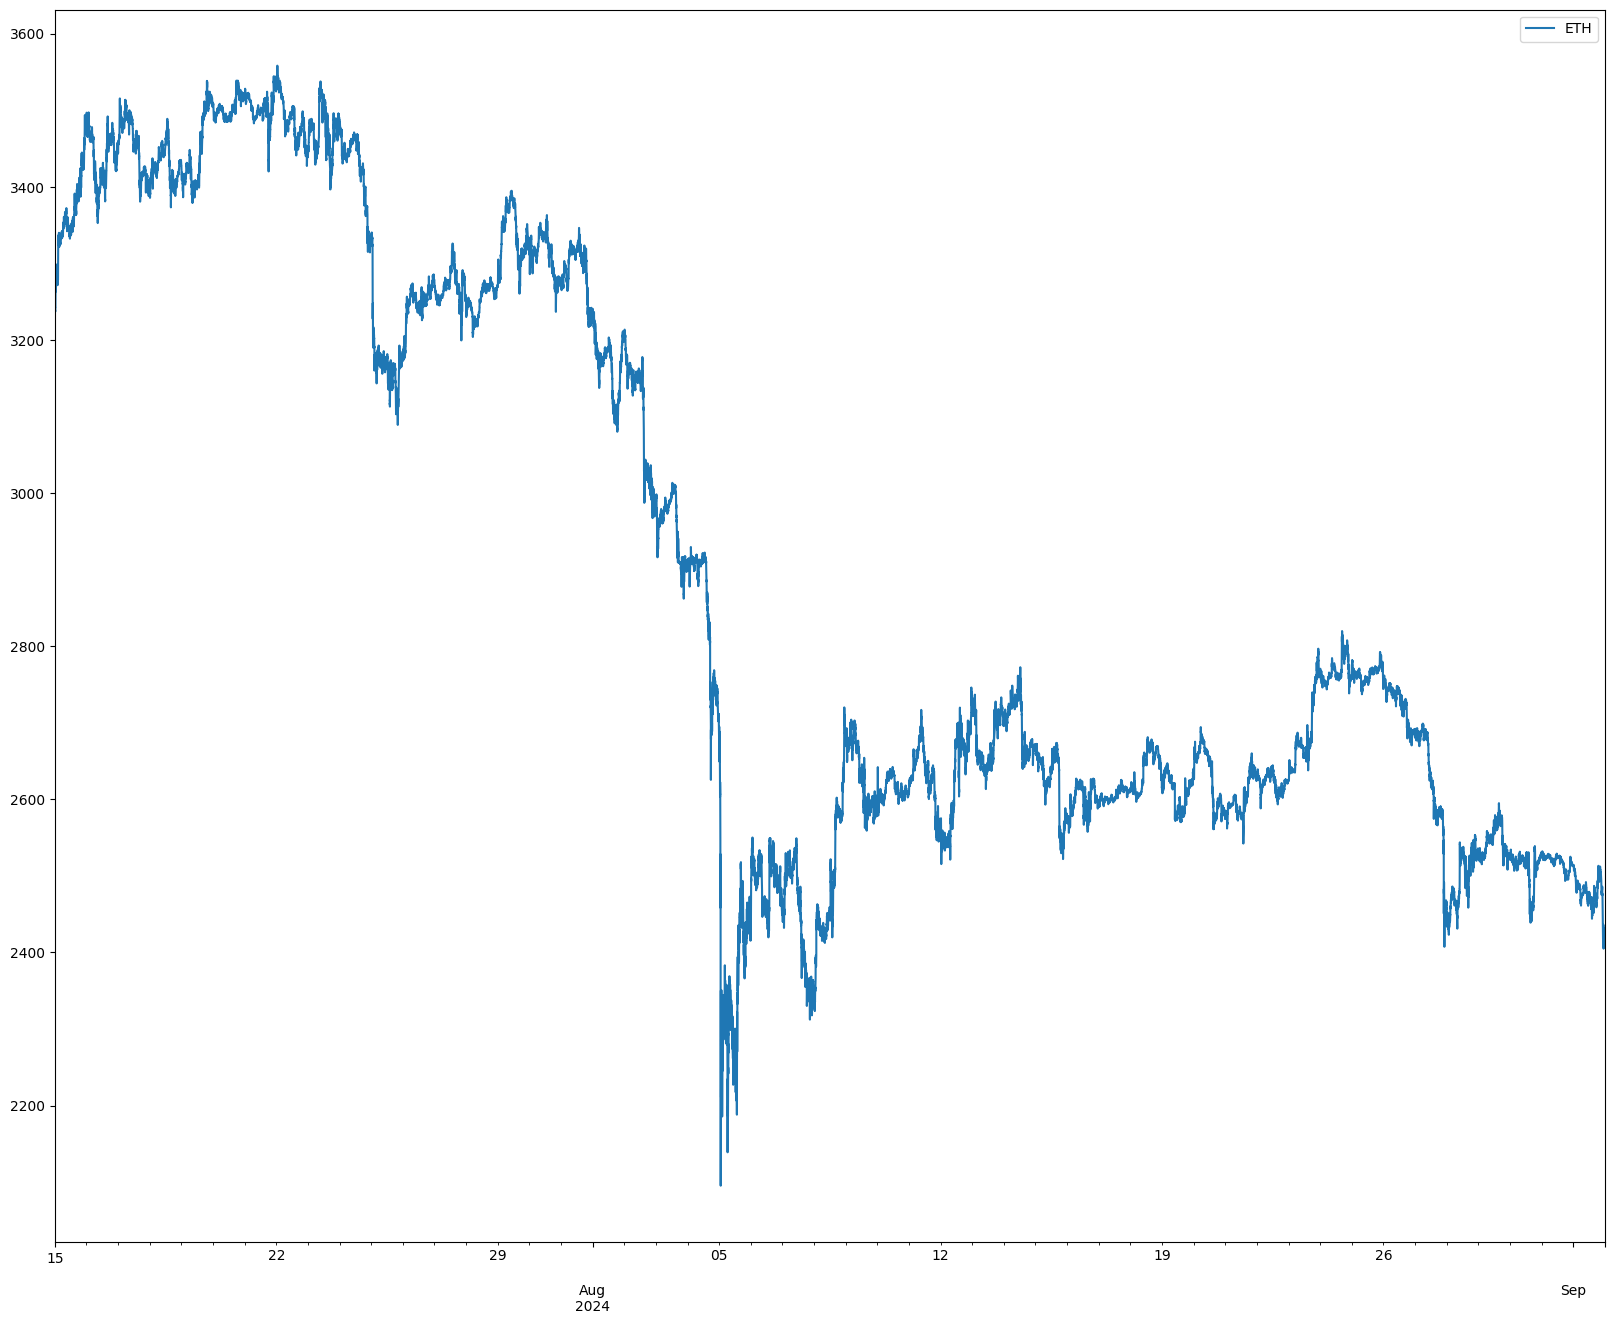

In [53]:
get_positions_info(actuator.actions, actuator.token_prices)

In [24]:
print({k: v for k, v in performance_metrics(
    actuator.account_status_df["net_value"], benchmark=actuator.account_status_df["price"]["ETH"]
).items()})


{Start period: Timestamp('2024-08-15 00:00:00'), End period: Timestamp('2024-09-01 23:59:00'), Duration: Timedelta('18 days 00:00:00'), Return: -98.68796841001813, Rate of Return: -0.049356326373687476, APR: -0.6416981334135023, Max Draw Down: 0.08367121298624564, Sharpe Ratio: -2.4940088015394544, Volatility: 0.2693246844193092, Alpha: -0.20382411951444784, Beta: 0.5167524534596539, Benchmark return rate: -0.08852887626871675, Benchmark APR: -0.847357397081643}


In [ ]:
df = actuator.strategy.data[market_key]